<a target="_blank" href="https://colab.research.google.com/github/Sebelino/DD2424-project/blob/main/e1_sebastian.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
%load_ext autoreload
%autoreload 2

import os
import socket

repo_name = "DD2424-project"
dep_filename = "download_dataset.py"
cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

if os.path.exists(dep_filename):
    print(f"{dep_filename} is in your current directory. Assuming you are in the root of the repository.")
elif not os.path.exists(repo_name):
    print(f"Cloning repo and fetching {dep_filename}...")
    !git clone https://github.com/Sebelino/DD2424-project
    !cp DD2424-project/download_dataset.py .
else:
    !git -C DD2424-project pull --rebase
    !cp DD2424-project/download_dataset.py .

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Host: deeplearning-vm
You are here: /home/silpasoninallacheruvu/DD2424-project
download_dataset.py is in your current directory. Assuming you are in the root of the repository.


# Train model

In [ ]:
from dataclasses import asdict
from util import json_dumps
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
%reload_ext autoreload
%autoreload 2

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import

from training import TrainParams, NagParams, AdamParams

baseline_params = TrainParams(
    seed=determinism.seed,
    batch_size=32,
    architecture="resnet50",
    n_epochs=10,
    optimizer=NagParams(
        learning_rate=0.01,
        weight_decay=1e-4,
        momentum=0.9,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    validation_freq=1,
    unfreeze_last_l_blocks = 1,
    time_limit_seconds=None,
    val_acc_target=None,
)

invalidate_cache_entry = True
if invalidate_cache_entry:
    run.call_and_shelve(baseline_params).clear()

# First plot: Training and validation accuracy
for l in range(1,6):
    baseline_params.unfreeze_last_l_blocks = l
    print("Training with params:")
    print(baseline_params.pprint())
    result = run(baseline_params)

    print("Training result:")
    print(result.pprint())
    evaluate_with_train_val_plot(result)

    # Second plot: Rerun training multiple times with different seed
    run_with_different_seeds(baseline_params, trials=3)

    # Third plot: Compare NAG with Adam
    experimental_params = baseline_params.copy()
    experimental_params.optimizer = AdamParams(learning_rate=0.001)
    
    param_sets = {
        "Baseline (NAG)": baseline_params,
        "Experiment (Adam)": experimental_params,
    }
    
    run_comparison(param_sets, trials=3)


# Train unsupervised model

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 5,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "augmentation": {
    "enabled": false
  },
  "unfreeze_last_l_blocks": 2,
  "fixmatch": true,
  "unsup_weight": 0.3,
  "pseudo_threshold": 0.95,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
Creating balanced split...


  0%|          | 0/3680 [00:00<?, ?it/s]

Creating balanced split...


  0%|          | 0/2946 [00:00<?, ?it/s]

[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.1535, Train Acc: 63.12%, Val Acc: 86.51%
Epoch [2/5], Loss: 0.4161, Train Acc: 90.44%, Val Acc: 91.42%
Epoch [3/5], Loss: 0.4053, Train Acc: 94.98%, Val Acc: 92.64%
Epoch [4/5], Loss: 0.3150, Train Acc: 97.29%, Val Acc: 90.60%
Epoch [5/5], Loss: 0.2677, Train Acc: 96.47%, Val Acc: 94.14%
Total elapsed: 101.15s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/be43fa1b0a06f07ca534869ad442af04.pth
Training result:
{
  "training_losses": [2.153505984773027, 0.41606612281596406, 0.40525475727255517, 0.31499415343191395, 0.2676833786189239],
  "training_accuracies": [0.6311864406779661, 0.9044067796610169, 0.9498305084745763, 0.9728813559322034, 0.9647457627118644],
  "validation_accuracies": [0.8651226158038147, 0.9141689373297003, 0.9264305177111717, 0.9059945504087193, 0.94141689373297],
  "update_steps": [93, 186, 279, 372, 465],
  "epochs": [1, 2, 3, 4, 5],
  "training_elapsed": 101.15007359099991
}


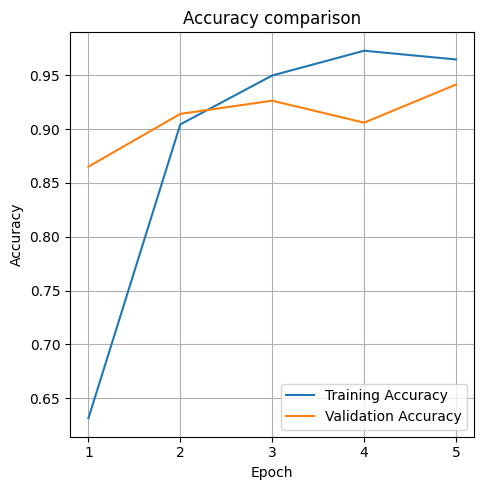

In [8]:
%reload_ext autoreload
%autoreload 2

from training import TrainParams, NagParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds, run_comparison
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams
from augmentation import AugmentationParams

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
   
dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    trainval_size=None,  # Load all training data
    #trainval_size=400,  # Load a subset
    validation_set_fraction=0.2,  # 20 % of trainval set
    labelled_data_fraction=0.5, # full labelled data first
)

baseline_params = TrainParams(
    seed=determinism.seed,
    architecture="resnet50",
    n_epochs=5,
    optimizer=NagParams(
        learning_rate=0.022630885203465553,
        weight_decay=8.478660307897792e-05,
        momentum=0.8063799868511693,
    ),
    freeze_layers=True,
    unfreezing_epochs=(2, 4),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
    unfreeze_last_l_blocks = 2,
    pseudo_threshold = 0.95,
    unsup_weight = 0.3,
    augmentation = AugmentationParams(
        enabled=False,
        transform=None
    ),
    fixmatch=True
)

run_args = (dataset_params, baseline_params)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 3.4365, Train Acc: 20.27%, Val Acc: 69.62%
Epoch [2/5], Loss: 2.3348, Train Acc: 77.70%, Val Acc: 73.98%
Epoch [3/5], Loss: 0.7417, Train Acc: 91.55%, Val Acc: 79.70%
Epoch [4/5], Loss: 0.2692, Train Acc: 97.64%, Val Acc: 80.65%
Epoch [5/5], Loss: 0.1401, Train Acc: 98.31%, Val Acc: 82.70%
Total elapsed: 125.77s, average per update step: 0.12s
[Trainer] Saved checkpoint to runs/checkpoints/cd9136053d4b62e5ca533b8fdc4fe3c6.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.6859, Train Acc: 48.48%, Val Acc: 84.74%
Epoch [2/5], Loss: 0.6468, Train Acc: 91.09%, Val Acc: 89.24%
Epoch [3/5], Loss: 0.1685, Train Acc: 97.63%, Val Acc: 92.51%
Epoch [4/5], Loss: 0.1522, Train Acc: 99.55%, Val Acc: 90.33%
Epoch [5/5], Loss: 0.5078, Train Acc: 95.04%, Val Acc: 91.96%
Total elapsed: 112.70s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/a67c5e39a3255752bc0c1bbe5c0e85de.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.1690, Train Acc: 62.24%, Val Acc: 86.65%
Epoch [2/5], Loss: 0.4217, Train Acc: 90.37%, Val Acc: 90.33%
Epoch [3/5], Loss: 0.4058, Train Acc: 94.64%, Val Acc: 91.96%
Epoch [4/5], Loss: 0.3367, Train Acc: 96.41%, Val Acc: 90.05%
Epoch [5/5], Loss: 0.2812, Train Acc: 96.75%, Val Acc: 92.92%
Total elapsed: 101.13s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/be43fa1b0a06f07ca534869ad442af04.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.7739, Train Acc: 69.66%, Val Acc: 90.60%
Epoch [2/5], Loss: 0.3073, Train Acc: 92.54%, Val Acc: 90.60%
Epoch [3/5], Loss: 0.1662, Train Acc: 97.62%, Val Acc: 91.83%
Epoch [4/5], Loss: 0.2142, Train Acc: 98.16%, Val Acc: 93.19%
Epoch [5/5], Loss: 0.1505, Train Acc: 98.98%, Val Acc: 94.55%
Total elapsed: 85.85s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/f91c1820c6202001b7f3e9c8a65bc1ea.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.5358, Train Acc: 73.24%, Val Acc: 91.69%
Epoch [2/5], Loss: 0.2953, Train Acc: 91.37%, Val Acc: 92.64%
Epoch [3/5], Loss: 0.1033, Train Acc: 98.44%, Val Acc: 94.28%
Epoch [4/5], Loss: 0.0882, Train Acc: 99.00%, Val Acc: 93.32%
Epoch [5/5], Loss: 0.0566, Train Acc: 99.26%, Val Acc: 94.41%
Total elapsed: 71.48s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/0677ddc10dd5efcea31be0d3d0bcb108.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.4617, Train Acc: 75.59%, Val Acc: 90.46%
Epoch [2/5], Loss: 0.2959, Train Acc: 91.68%, Val Acc: 92.23%
Epoch [3/5], Loss: 0.0907, Train Acc: 98.00%, Val Acc: 92.10%
Epoch [4/5], Loss: 0.0460, Train Acc: 99.12%, Val Acc: 92.37%
Epoch [5/5], Loss: 0.0394, Train Acc: 99.36%, Val Acc: 92.23%
Total elapsed: 64.85s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/fb0ec0976a94110a139010cb40e975b1.pth


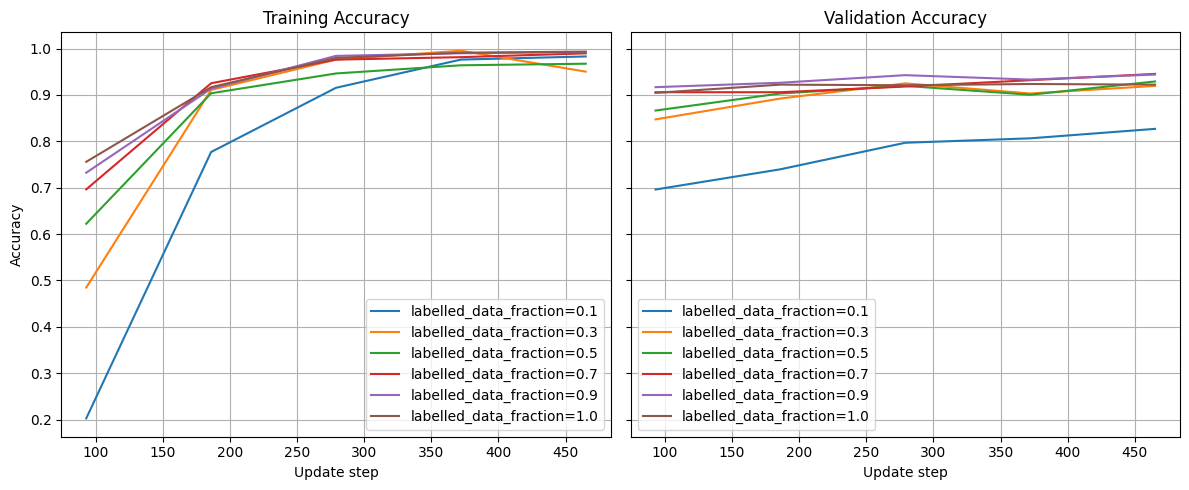

In [10]:
from evaluation import run_dataset_comparison

def tweak(params: DatasetParams, labelled_data_fraction):
    params = params.copy()
    params.labelled_data_fraction = labelled_data_fraction
    return params
 
#plot: Compare unsupervised learning for different fractions of unlabelled data
labelled_data_fractions = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
param_sets = {f"labelled_data_fraction={data_fraction}": tweak(dataset_params, labelled_data_fraction=data_fraction) for data_fraction in labelled_data_fractions}

run_dataset_comparison(param_sets, baseline_params)


[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 5.7104, Train Acc: 11.49%, Val Acc: 59.26%
Epoch [2/5], Loss: 3.8634, Train Acc: 32.43%, Val Acc: 55.72%
Epoch [3/5], Loss: 3.6638, Train Acc: 47.64%, Val Acc: 72.75%
Epoch [4/5], Loss: 1.6790, Train Acc: 69.59%, Val Acc: 74.52%
Epoch [5/5], Loss: 0.9063, Train Acc: 87.84%, Val Acc: 80.65%
Total elapsed: 131.08s, average per update step: 0.11s
[Trainer] Saved checkpoint to runs/checkpoints/92b07fb42e37ee89d7c64793feb6ec82.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 3.5401, Train Acc: 47.80%, Val Acc: 83.38%
Epoch [2/5], Loss: 1.3412, Train Acc: 79.03%, Val Acc: 88.01%
Epoch [3/5], Loss: 0.7265, Train Acc: 91.88%, Val Acc: 90.60%
Epoch [4/5], Loss: 0.6855, Train Acc: 96.73%, Val Acc: 90.46%
Epoch [5/5], Loss: 0.8174, Train Acc: 97.63%, Val Acc: 91.83%
Total elapsed: 116.22s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/1c4f06df633539cdbae63102452713c7.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.6115, Train Acc: 60.61%, Val Acc: 86.92%
Epoch [2/5], Loss: 0.7849, Train Acc: 85.36%, Val Acc: 91.14%
Epoch [3/5], Loss: 0.5864, Train Acc: 94.17%, Val Acc: 92.64%
Epoch [4/5], Loss: 0.6042, Train Acc: 97.08%, Val Acc: 90.05%
Epoch [5/5], Loss: 0.5161, Train Acc: 97.15%, Val Acc: 93.73%
Total elapsed: 101.98s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/5eaae3e953accca1410ff8891327c104.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 2.0554, Train Acc: 68.15%, Val Acc: 89.37%
Epoch [2/5], Loss: 0.5491, Train Acc: 89.29%, Val Acc: 89.37%
Epoch [3/5], Loss: 0.3812, Train Acc: 96.41%, Val Acc: 90.46%
Epoch [4/5], Loss: 0.2324, Train Acc: 98.89%, Val Acc: 93.87%
Epoch [5/5], Loss: 0.2234, Train Acc: 99.71%, Val Acc: 95.10%
Total elapsed: 86.61s, average per update step: 0.10s
[Trainer] Saved checkpoint to runs/checkpoints/f2a46ef949bb48422d0ca4cbc3de5f56.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.6537, Train Acc: 72.31%, Val Acc: 90.46%
Epoch [2/5], Loss: 0.3899, Train Acc: 90.62%, Val Acc: 92.23%
Epoch [3/5], Loss: 0.1546, Train Acc: 98.14%, Val Acc: 93.32%
Epoch [4/5], Loss: 0.1024, Train Acc: 99.11%, Val Acc: 93.60%
Epoch [5/5], Loss: 0.0886, Train Acc: 99.37%, Val Acc: 93.19%
Total elapsed: 71.60s, average per update step: 0.11s
[Trainer] Saved checkpoint to runs/checkpoints/6fe84e82b6afcd93c40b3ca52584b493.pth
[Trainer] Unfroze last 2 blocks


Update step:   0%|          | 0/465 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.4581, Train Acc: 75.53%, Val Acc: 90.74%
Epoch [2/5], Loss: 0.2984, Train Acc: 91.82%, Val Acc: 91.83%
Epoch [3/5], Loss: 0.0917, Train Acc: 97.90%, Val Acc: 91.55%
Epoch [4/5], Loss: 0.0434, Train Acc: 99.25%, Val Acc: 92.64%
Epoch [5/5], Loss: 0.0371, Train Acc: 99.59%, Val Acc: 92.51%
Total elapsed: 62.90s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/d619deee624ee659f342a960a7845a8b.pth


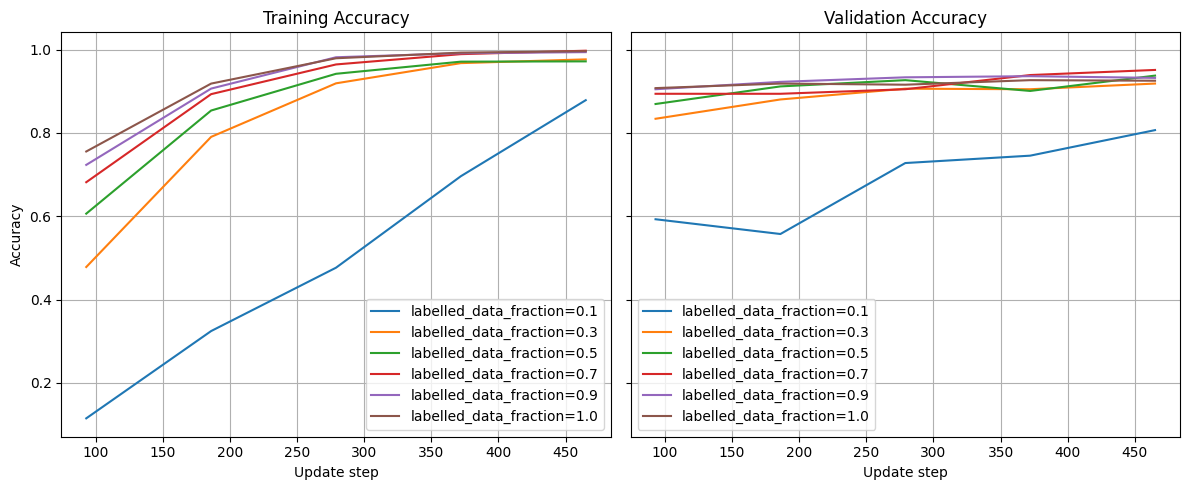

In [11]:
from evaluation import run_dataset_comparison

def tweak(params: DatasetParams, labelled_data_fraction):
    params = params.copy()
    params.labelled_data_fraction = labelled_data_fraction
    return params
 
#plot: Compare unsupervised learning for different fractions of unlabelled data along with threshold
labelled_data_fractions = [ 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
param_sets = {f"labelled_data_fraction={data_fraction}": tweak(dataset_params, labelled_data_fraction=data_fraction) for data_fraction in labelled_data_fractions}

baseline_params.pseudo_threshold = None
run_dataset_comparison(param_sets, baseline_params)


# Test model

In [20]:
from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer

baseline_params.pseudo_threshold = None
training_params = baseline_params

print("Training with params:")
print(training_params.pprint())

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 5,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "augmentation": {
    "enabled": false
  },
  "unfreeze_last_l_blocks": 2,
  "fixmatch": true,
  "unsup_weight": 0.3,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/5eaae3e953accca1410ff8891327c104.pth (epoch 5)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 91.22%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 91.22%
Number of misclassified samples: 322


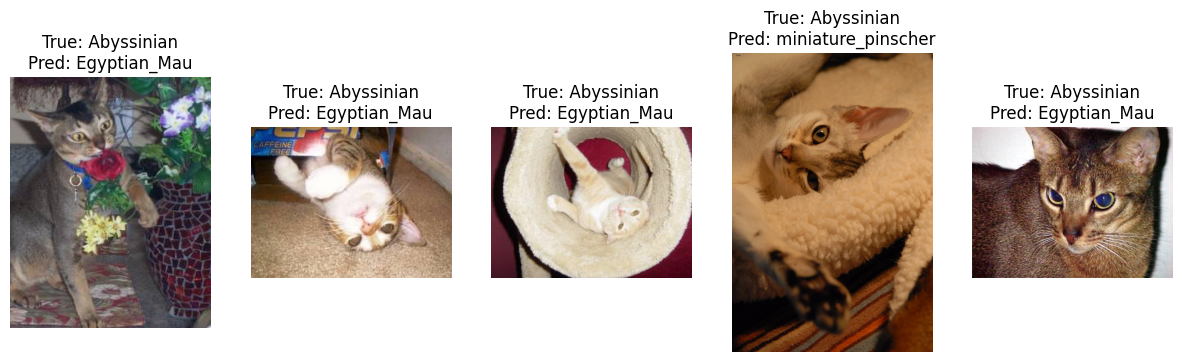

Copied 322 misclassified images to ./misclassified


In [21]:
from evaluation import show_misclassified

final_test_acc, misclassified_samples = evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples)}")
show_misclassified(misclassified_samples)

In [22]:
from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer

baseline_params.pseudo_threshold = 0.95
training_params = baseline_params

print("Training with params:")
print(training_params.pprint())

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(training_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.022630885203465553,
    "weight_decay": 8.478660307897792e-05,
    "momentum": 0.8063799868511693,
    "name": "nag"
  },
  "n_epochs": 5,
  "freeze_layers": true,
  "unfreezing_epochs": [2, 4],
  "validation_freq": 1,
  "augmentation": {
    "enabled": false
  },
  "unfreeze_last_l_blocks": 2,
  "fixmatch": true,
  "unsup_weight": 0.3,
  "pseudo_threshold": 0.95,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}
Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/be43fa1b0a06f07ca534869ad442af04.pth (epoch 5)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 91.50%


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

Final Test Accuracy: 91.50%
Number of misclassified samples: 312


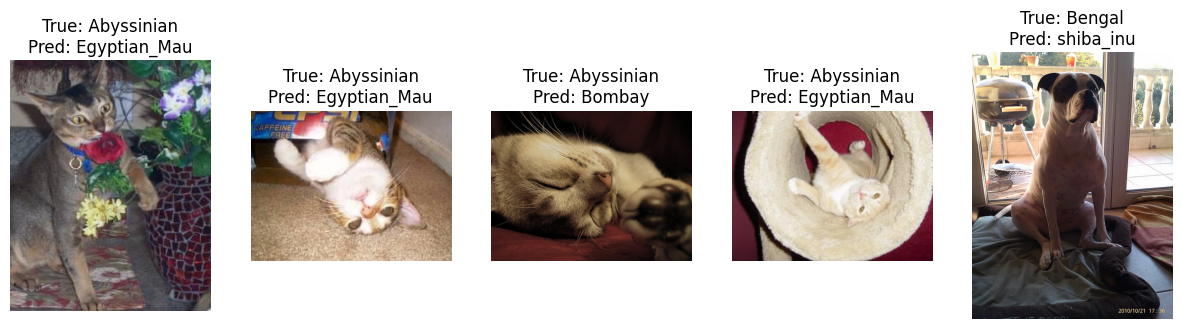

Copied 312 misclassified images to ./misclassified


In [23]:
from evaluation import show_misclassified

final_test_acc_tau, misclassified_samples_tau = evaluate_test_accuracy_and_misclassified(trainer, test_loader, test_dataset)
print(f"Final Test Accuracy: {final_test_acc_tau:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_samples_tau)}")
show_misclassified(misclassified_samples_tau)

Difference of misclassified samples: 240


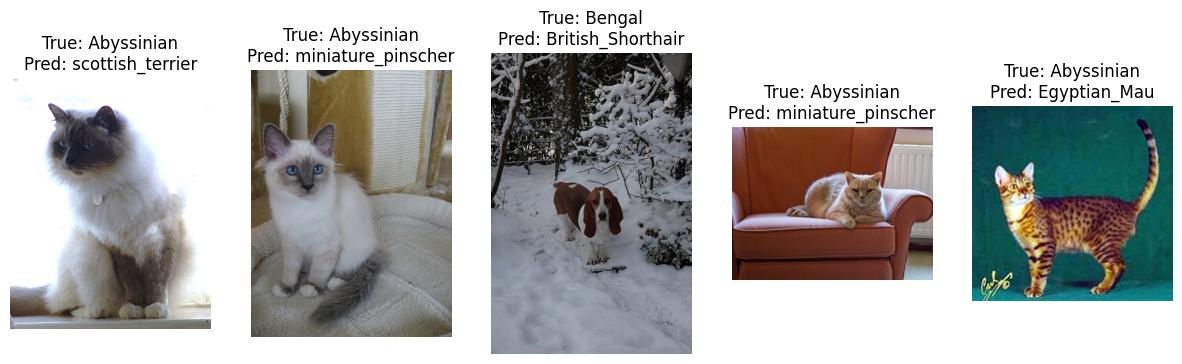

Copied 240 misclassified images to ./misclassified


In [25]:
misclassified_diff = list(set(misclassified_samples).symmetric_difference(misclassified_samples_tau))
print(f"Difference of misclassified samples: {len(misclassified_diff)}")
show_misclassified(misclassified_diff)

Difference of misclassified samples: 125


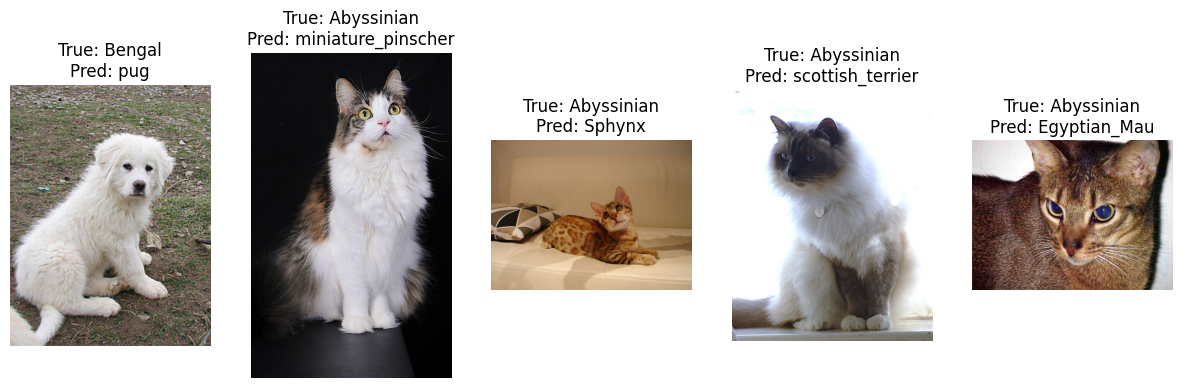

Copied 125 misclassified images to ./misclassified


In [26]:
misclassified_diff2 = list(set(misclassified_samples) - set(misclassified_samples_tau))
print(f"Difference of misclassified samples: {len(misclassified_diff2)}")
show_misclassified(misclassified_diff2)